# Mixture of Multivariate Normals
We simulate a dataset $\left\lbrace x_i\right\rbrace_i^n$ where each datapoint comes from one of $m$ $p$-variate normal with mean $\mu$ and variance-covariance matrix $\Sigma$, chosen with probability $\pi_j$ and then we try to estimate all the parameters via the maximization of the loglikelihood function

$$ \mathcal{L}(\pi, \mu, \Sigma) = \sum_i^n\log\left[\sum_j^m\pi_j\phi_{p}(x_i, \mu_j, \Sigma_j)\right] $$


where $\phi_{p}(x, \mu_j, \Sigma_j)$ is the $j$th density function of a $p$-variate gaussian distribution with mean $\mu_j$ and variance $\Sigma_j$.


We perform two reparametrization to simplify computations:
 - The first one is done via data augmentation to obtain a convex function for the likelihood by expanding the data adding a column of ones as $ y_i^\top = \left[x_i^\top 1 \right]$. It can be proven that if $\hat{\Omega}$ is the maximizer for this expanded problem's likelihood, $\tilde{\mathcal{L}}(\Omega)$ and $(\hat\mu, \hat\Sigma)$ are the maximizer for $\mathcal{L}(\mu,\Sigma)$, *then*

$$ 

\hat\Omega = \begin{pmatrix} 
        \hat\Sigma + \hat\mu\hat\mu^\top & \hat\mu \\
        \hat\mu^\top & 1 
    \end{pmatrix}.
$$

- The second is to compute $\nu_j = \log\left(\frac{\pi_j}{\pi_m}\right)$ (with $j=1,\dots,m-1$) and $\nu_m = 0$.

Thus, the final cost function over which we need to perform the optimization is

$$
\tilde{\mathcal{L}}(\nu, \Omega) = \sum_i^n\log\left(\sum_j^m \frac{\exp(\nu_j)}{\sum_k^m\exp(\nu_k)}\phi_{p+1}(y_i,0, \Omega_j)\right)
$$

In this case, the search space is the product $\mathbb{R}^{m-1}\times \prod_j^m\mathcal{S}^{p+1}_{+}$ where the endowed metric is the combination of the euclidean and the one defined for the SPD space.






In [16]:
import jax.numpy as jnp
from jax import jit, random, grad
from jax.scipy.special import logsumexp
from jax.ops import index, index_update
from jax.config import config
config.update('jax_enable_x64', True)

from tqdm.notebook import trange

seed = 0
RNG = random.PRNGKey(seed)

from libs.manifold import SPD, Euclidean, Product
from libs.minimizer import OPTIM

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("notebook")
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 7]


## Data generation
We first randomly generate $\pi_j$, $\mu_j$ and $\Sigma_j$ and then from those we generate the actual samples.


In [17]:
N = 1000
D = 2
M = 3
_tol = 1e-6

RNG, key = random.split(RNG); key = random.split(key, 3)
pi = random.uniform(key[0], shape=(M,)); pi = pi / pi.sum()
# print(pi)

mu = random.uniform(key[1], shape=(M, D), minval=-5, maxval=5)
# print(mu)

cov = random.normal(key[2], shape=(M, D, D)); cov = jnp.matmul(cov, jnp.swapaxes(cov, -2, -1))
# print(cov)

RNG, key = random.split(RNG)
components = random.choice(key, M, shape=(N,), p=pi)

samples = jnp.zeros(shape=(N, D), dtype=float)
RNG, *key = random.split(RNG, M + 1)
for j in range(M):
    idxs = j == components
    n_j = idxs.sum()
    if n_j > 0:
        x = random.multivariate_normal(key[j], mean=mu[j], cov=cov[j], shape=(n_j,))
        samples = index_update(samples, 
                               index[idxs, :], 
                               x)

true_S = jnp.array([jnp.append(jnp.append(cov[j] + jnp.outer(mu[j], mu[j]), jnp.array([mu[j]]), axis=0), jnp.array([jnp.append(mu[j], 1)]).T, axis=1)  for j in range(M)])
true_eta = jnp.array([jnp.log(pi[j]/pi[-1]) for j in range(M-1)])

piemp = jnp.array([jnp.mean(components == i) for i in range(M)])
muemp = jnp.array([jnp.mean(samples[components == i], axis=0) for i in range(M)])
covemp = jnp.array([(samples[components == i].T @ samples[components == i]) / jnp.sum(components == i) for i in range(M)])

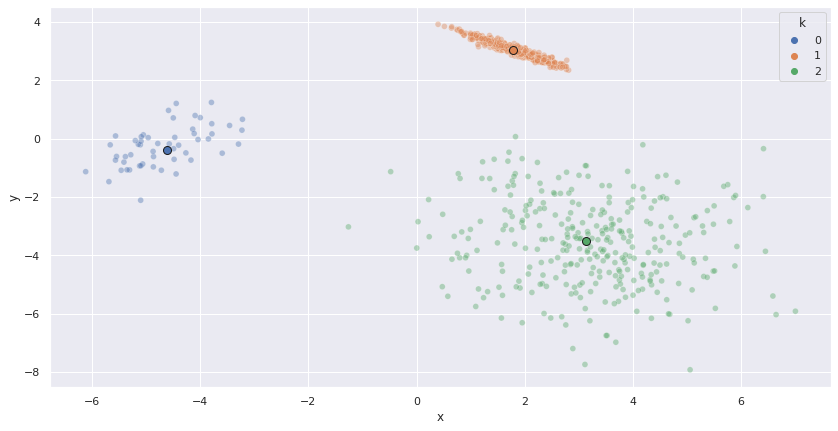

In [18]:
if D == 2:
    df = pd.DataFrame({'x':samples[:, 0], 'y':samples[:, 1], 'k':components})
    df['pi'] = df.k.apply(lambda x: pi[x])
    df.k = df.k.astype('category')
    colors = sns.color_palette()[:M]
    sns.scatterplot(data=df, x='x', y='y', hue='k', alpha=0.4)
    for j in range(M):
        plt.plot(mu[j,0], mu[j,1], 'o', color=colors[j], markeredgecolor='k', markersize=8)
    plt.show()

In [19]:
def costfunction(params):
    # prepare data and parameters
    S, v = tuple(params)
    y = jnp.concatenate([samples.T, jnp.ones(shape=(1,N))], axis=0)
    eta = jnp.append(v, 0)
    
    # compute logq
    data_part = jnp.einsum('ik,jkh,hi->ij', y.T, jnp.linalg.inv(S), y, optimize='greedy')
    logdetS = jnp.linalg.slogdet(S)[1]
    log_q = - 0.5 * (data_part + logdetS)
    
    # probability of belonging to each cluster
    alpha = jnp.exp(eta)
    alpha = alpha / jnp.sum(alpha)
    
    return - jnp.sum(logsumexp(jnp.log(alpha) + log_q, axis=1))

cost = jit(costfunction)
gr_cost = jit(grad(cost))
f = cost([true_S, true_eta])
g = gr_cost([true_S, true_eta])
print(f)

275.4784066218632


In [20]:
man = Product([SPD(D+1, M), Euclidean(M-1)])
optim = OPTIM(man, method='rsd', maxiter=1000, mingradnorm=_tol, verbosity=1, logverbosity=True)

RNG, key = random.split(RNG)
results, logs = optim.solve(cost, gr_cost, key=key)

print(results)

Optimizing...
Starting Riemannian Steepest Descent on the product manifold: product manifold of 3 (3 x 3) positive definite matrices x r^2


AttributeError: 'NoneType' object has no attribute 'append'

In [6]:
muhat = jnp.array([results.x[0][j][-1, :-1] for j in range(M)])

covhat = jnp.array([results.x[0][j][:-1, :-1] - jnp.dot(muhat[j], muhat[j].T) for j in range(M)])

pihat = jnp.exp(jnp.append(results.x[1], 0))
pihat = pihat / jnp.sum(pihat)

In [7]:
for j in range(M):
    print(mu[j])
    print(muhat[j],'\n')

for j in range(M):
    print(jnp.linalg.eigvalsh(cov[j]))
    print(jnp.linalg.eigvalsh(covhat[j]), '\n')

for j in range(M):
    print(pi[j])
    print(pihat[j],'\n')

[-4.62044652 -0.37875652]
[1.79254084 3.04875934] 

[1.78566113 3.05172257]
[-1.4182631   1.05700062] 

[ 3.14673668 -3.50346223]
[ 2.08638913 -3.10105575] 

[0.23030879 0.72168831]
[-13.88460828   1.60595723] 

[0.0039945  0.22669998]
[0.80550706 9.48509851] 

[1.90648415 2.22702786]
[-24.49064601  23.26166007] 

0.06084145746599177
0.6338849137208034 

0.6345369765567997
0.0007627122308414908 

0.30462156597720846
0.3653523740483551 



In [8]:
from sklearn.mixture import GaussianMixture as GM

gm = GM(n_components=M).fit(samples)
print(gm.means_)
print(mu,'\n')

print(gm.weights_)
print(pi)

[[ 3.22916979 -3.58085086]
 [ 1.7928435   3.04858137]
 [-4.6794676  -0.26507184]]
[[-4.62044652 -0.37875652]
 [ 1.78566113  3.05172257]
 [ 3.14673668 -3.50346223]] 

[0.3130065  0.63399366 0.05299985]
[0.06084146 0.63453698 0.30462157]


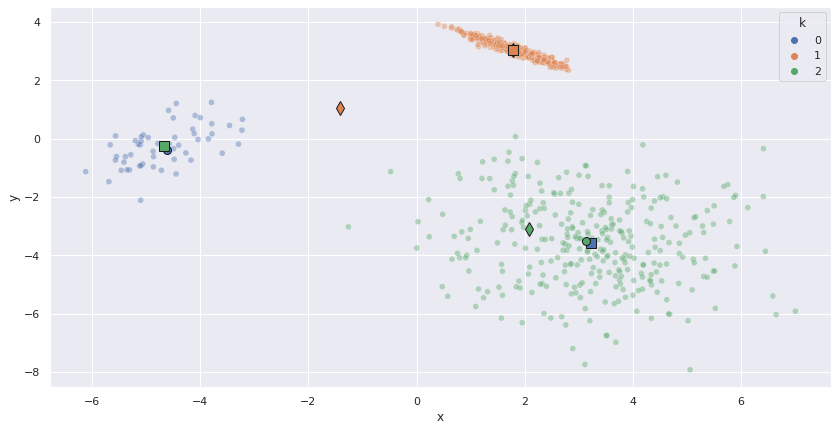

[0.06084146 0.63453698 0.30462157]
[0.3130065  0.63399366 0.05299985]
          x         y
k                    
0 -4.679464 -0.265071
1  1.792850  3.048578
2  3.229189 -3.580981
[[-4.62044652 -0.37875652]
 [ 1.78566113  3.05172257]
 [ 3.14673668 -3.50346223]]

[[ 3.22916979 -3.58085086]
 [ 1.7928435   3.04858137]
 [-4.6794676  -0.26507184]]


In [9]:
if D == 2:
    df = pd.DataFrame({'x':samples[:, 0], 'y':samples[:, 1], 'k':components})
    df_sim = pd.DataFrame({'x':samples[:, 0], 'y':samples[:, 1], 'k':gm.predict(samples)})
    df.k = df.k.astype('category')
    df_sim.k = df_sim.k.astype('category')
    
    colors = sns.color_palette()[:M]
    sns.scatterplot(data=df, x='x', y='y', hue='k', alpha=0.4)
    for j in range(M):
        plt.plot(mu[j, 0], mu[j, 1], 'o', color=colors[j], markersize=8, markeredgecolor='k')
        plt.plot(muhat[j,0], muhat[j,1], 'd', color=colors[j], markeredgecolor='k', markersize=10)
        plt.plot(gm.means_[j, 0], gm.means_[j, 1], 's', color=colors[j], markeredgecolor='k', markersize=10)
    plt.show()
    print(pi)
    print(gm.weights_)

    print(df.groupby('k').mean())
    print(mu)
    print()
    print(gm.means_)